In [2]:
import pandas as pd
import numpy as np
import zipfile

## Import Data

In [3]:
# ! wget -P ../../data/raw https://aqua.kingcounty.gov/extranet/assessor/Parcel.zip
# ! wget -P ../../data/raw https://aqua.kingcounty.gov/extranet/assessor/Real%20Property%20Sales.zip
# ! wget -P ../../data/raw https://aqua.kingcounty.gov/extranet/assessor/Residential%20Building.zip

In [4]:
# with zipfile.ZipFile('../../data/raw/Parcel.zip', 'r') as zip_ref:
#     zip_ref.extractall('../../data/raw')
# with zipfile.ZipFile('../../data/raw/Real Property Sales.zip', 'r') as zip_ref:
#     zip_ref.extractall('../../data/raw')
# with zipfile.ZipFile('../../data/raw/Residential Building.zip', 'r') as zip_ref:
#     zip_ref.extractall('../../data/raw')

In [5]:
parcel = pd.read_csv("../../data/raw/EXTR_Parcel.csv", encoding='latin-1')
real_property_sales = pd.read_csv("../../data/raw/EXTR_RPSale.csv", encoding='latin-1', low_memory=False)
residential_building = pd.read_csv("../../data/raw/EXTR_ResBldg.csv", encoding='latin-1', low_memory=False)

## Clean Data and Filter For Needed Info

In [6]:
# Real Property Sales
# Identifyers are Major and Minor. Relevant data is SalePrice
# Clean real_property_sales to have proper values in Minor and Major and change type to int to match other data sets
real_property_sales = real_property_sales[['Major', 'Minor', 'SalePrice', 'DocumentDate']]
real_property_sales = real_property_sales[(real_property_sales['Major'].str.isdecimal()==True) &
                                          (real_property_sales['Minor'].str.isdecimal()==True)]
real_property_sales['Major'] = real_property_sales['Major'].astype('int64')
real_property_sales['Minor'] = real_property_sales['Minor'].astype('int64')
real_property_sales = real_property_sales[real_property_sales['SalePrice']>0]

In [7]:
real_property_sales.head()

,Major,Minor,SalePrice,DocumentDate
0,138860,110,245000,08/21/2014
4,213043,120,560000,12/20/2019
5,951120,900,85000,04/20/1989
7,122209,9002,5755000,04/25/2001
8,122209,9001,5755000,04/25/2001


In [8]:
# Parcel Filter for Necessary Columns
parcel = parcel[['Major', 'Minor', 'PropType', 'SqFtLot', 'WfntLocation',
                 'TrafficNoise', 'AirportNoise', 'PowerLines', 'OtherNuisances']]
parcel.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 616089 entries, 0 to 616088
Data columns (total 9 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   Major           616089 non-null  int64 
 1   Minor           616089 non-null  int64 
 2   PropType        616089 non-null  object
 3   SqFtLot         616089 non-null  int64 
 4   WfntLocation    616089 non-null  int64 
 5   TrafficNoise    616089 non-null  int64 
 6   AirportNoise    616089 non-null  int64 
 7   PowerLines      616089 non-null  object
 8   OtherNuisances  616089 non-null  object
dtypes: int64(6), object(3)
memory usage: 42.3+ MB


In [9]:
parcel = parcel[(parcel['PropType']=='R')]

In [10]:
# Residential Buiding Filter For Necessary Columns
residential_building = residential_building[['Major', 'Minor', 'NbrLivingUnits', 'SqFtTotLiving', 'SqFtOpenPorch', 'SqFtEnclosedPorch']]

In [11]:
# Create a column Has_Porch
residential_building['Has_Porch']= residential_building['SqFtOpenPorch'] + residential_building['SqFtEnclosedPorch']
residential_building['Has_Porch'] = [1  if p>0 else 0 for p in residential_building['Has_Porch']]

In [12]:
residential_building.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517554 entries, 0 to 517553
Data columns (total 7 columns):
 #   Column             Non-Null Count   Dtype
---  ------             --------------   -----
 0   Major              517554 non-null  int64
 1   Minor              517554 non-null  int64
 2   NbrLivingUnits     517554 non-null  int64
 3   SqFtTotLiving      517554 non-null  int64
 4   SqFtOpenPorch      517554 non-null  int64
 5   SqFtEnclosedPorch  517554 non-null  int64
 6   Has_Porch          517554 non-null  int64
dtypes: int64(7)
memory usage: 27.6 MB


In [22]:
# Join all the tables on Major, Minor
# Have duplicate buildings sold at different dates. Need to only keep latest dates
merged_tables = (parcel.merge(real_property_sales, on = ['Major', 'Minor'])).merge(residential_building, on = ['Major', 'Minor']).drop_duplicates()
# Change dates to date time format
merged_tables[['Major', 'SqFtLot']].head(20)
merged_tables['DocumentDate'] = pd.to_datetime(merged_tables['DocumentDate'])

In [23]:
merged_tables.shape

(990905, 16)

In [24]:
#Keeping only the most recent Sale_Price

# df = df.sort_values(by=['IDName', 'Time'])

# merged_tables.sort_values(by =['Major', 'Minor', 'DocumentDate']).drop_duplicates(subset = ['Major', 'Minor'], keep='last', inplace=True)
# df.groupby('A', group_keys=False).apply(lambda x: x.loc[x.B.idxmax()])

# merged_tables.groupby(['Major', 'Minor'], group_keys=False).apply(lambda x: x.loc[np.argmax(x['DocumentDate'])])

# merged_tables = merged_tables.sort_values(by=['Major', 'DocumentDate'])
# merged_tables.drop_duplicates(subset=['Major', 'Minor'], keep='last', inplace=True)

In [25]:
start_date = "2019-1-1"
end_date = "2019-12-31"
merged_tables = merged_tables.loc[(merged_tables["DocumentDate"] >= start_date) & (merged_tables["DocumentDate"] <= end_date)]

# merged_tables = merged_tables.loc['DocumentDate']=='2019']
# merged_tables[['Major', 'Minor', 'SqFtLot']].sample(20)
merged_tables.shape

(29983, 16)

In [26]:
# Sort by Document Date
df = merged_tables #.sort_values(by = 'DocumentDate', ascending=False)

#Create Nuisances Column to replace other nuisance columns
df['Nuisances'] = 'No Nuisances'
df.loc[(df['TrafficNoise']>0), 'Nuisances'] = 'Traffic Noise'
df.loc[(df['AirportNoise']>0), 'Nuisances'] = 'Airport Noise'
df.loc[(df['PowerLines']=='Y'), 'Nuisances'] = 'Power Lines'
df.loc[(df['OtherNuisances']=='Y'), 'Nuisances'] = 'Other Nuisances'
df = df.drop(['TrafficNoise', 'AirportNoise', 'PowerLines', 'OtherNuisances', 'SqFtOpenPorch', 'SqFtEnclosedPorch'], axis='columns')

In [27]:
# WFNTLOCATION
# Waterfront location (Source: King County Assessments)
# Value	Definition
# 0	Unknown
# 1	Duwamish
# 2	Elliott Bay
# 3	Puget Sound
# 4	Lake Union
# 5	Ship Canal
# 6	Lake Washington
# 7	Lake Sammamish
# 8	Other lake
# 9	River or slough

df['WaterFrontLocation'] = df.WfntLocation.map({0 : 'None', 1 : 'Duwamish', 2 : 'Elliott Bay', 3 : 'Puget Sound', 4 : 'Lake Union',
                     5 : 'Ship Canal',  6 : 'Lake Washington', 7 : 'Lake Sammamish', 8 : 'Other lake', 9 : 'River or slough'})
df['Is_WaterFrontLocation'] = [1 if i>0 else 0 for i in df.WfntLocation]
df=df.drop('WfntLocation', axis='columns')

In [28]:
df['Has_Nuisance'] = [0 if n == 'No Nuisances' else 1 for n in df['Nuisances']]

# df[['Major', 'Minor', 'SqFtLot']].head()
df.head()

,Major,Minor,PropType,SqFtLot,SalePrice,DocumentDate,NbrLivingUnits,SqFtTotLiving,Has_Porch,Nuisances,WaterFrontLocation,Is_WaterFrontLocation,Has_Nuisance
60,513763,80,R,5239,612000,2019-03-01,1,2798,1,No Nuisances,None,0,0
64,152407,9065,R,254390,1500,2019-10-24,1,1630,1,Traffic Noise,None,0,1
65,152407,9065,R,254390,1500,2019-10-24,1,930,1,Traffic Noise,None,0,1
113,278732,710,R,7416,395000,2019-03-20,1,1820,0,No Nuisances,None,0,0
154,868230,1740,R,4878,622000,2019-07-30,1,1510,1,No Nuisances,None,0,0


In [29]:
# Check x if have the relevant data to answer question
# [x]Higher square footage increases home sale price1, 2
# [x]Having a porch increases home sale price3, 4
# [x]Having a beachfront or lakefront increases home sale price5
# [x]The house filling a higher proportion of the overall lot decreases home sale price6
# [x]The cost per square foot is lower in duplexes than in single-family homes7
# [x]The presence of a nuisance (power lines, traffic noise, airport noise) decreases home sale price1, 5

## Graphical EDA

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns

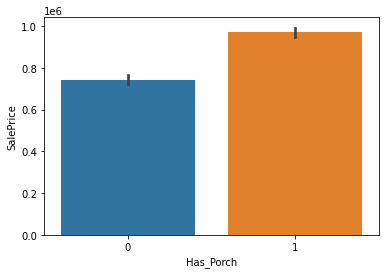

In [31]:
sns.barplot(df['Has_Porch'], df['SalePrice']);

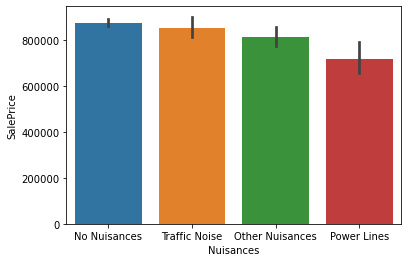

In [32]:
sns.barplot(df['Nuisances'], df['SalePrice']);

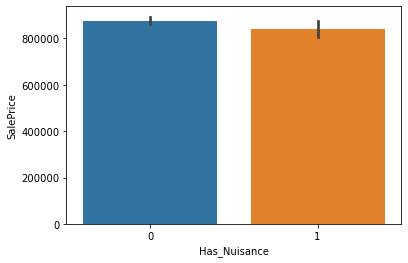

In [33]:
sns.barplot(df['Has_Nuisance'], df['SalePrice']);

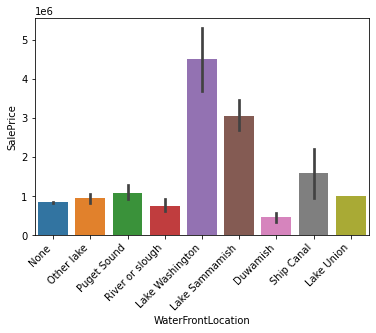

In [34]:
chart = sns.barplot(df.WaterFrontLocation, df.SalePrice)
chart.set_xticklabels(chart.get_xticklabels(), rotation=45, horizontalalignment='right');

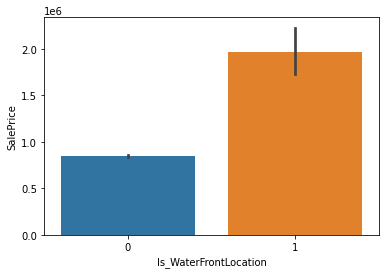

In [35]:
sns.barplot(df.Is_WaterFrontLocation, df.SalePrice);

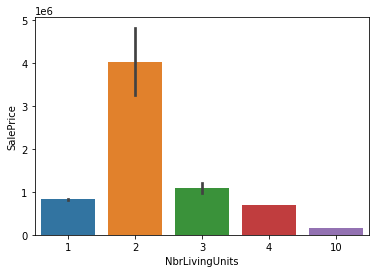

In [36]:
sns.barplot(df.NbrLivingUnits, df.SalePrice);

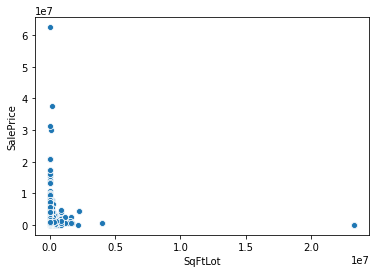

In [37]:
sns.scatterplot(df['SqFtLot'], df['SalePrice'])

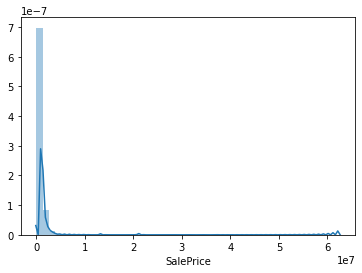

In [38]:
sns.distplot(df['SalePrice'])

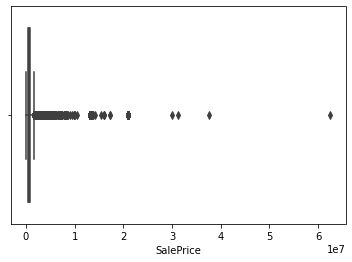

In [39]:
sns.boxplot(df['SalePrice'])

In [40]:
df2 = df[df['SalePrice'].between(df['SalePrice'].quantile(.15), df['SalePrice'].quantile(.85))]

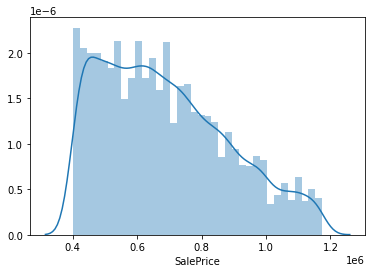

In [41]:
sns.distplot(df2['SalePrice'])

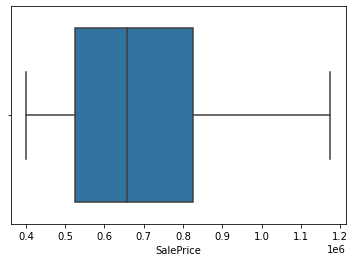

In [42]:
sns.boxplot(df2['SalePrice'])

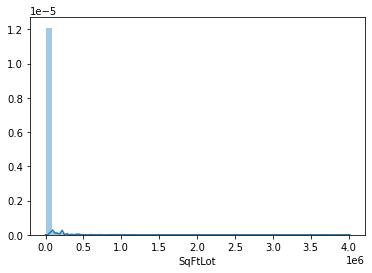

In [43]:
sns.distplot(df2['SqFtLot'])

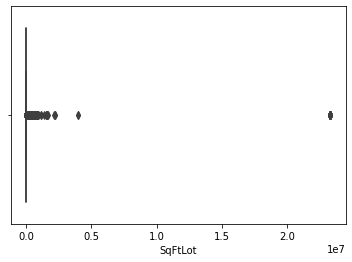

In [44]:
sns.boxplot(df['SqFtLot'])

In [45]:
df2 = df[df['SqFtLot'].between(df['SqFtLot'].quantile(.15), df['SqFtLot'].quantile(.85))]

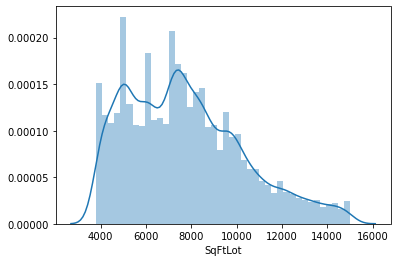

In [46]:
sns.distplot(df2['SqFtLot'])

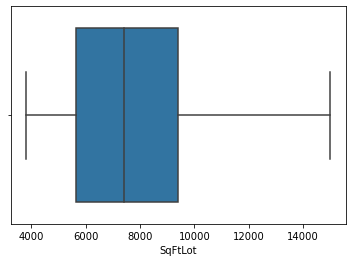

In [47]:
sns.boxplot(df2['SqFtLot'])

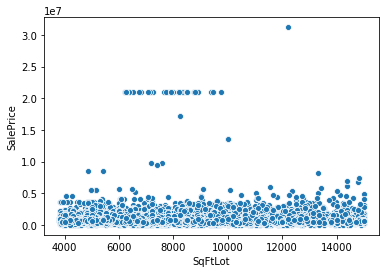

In [48]:
sns.scatterplot(df2['SqFtLot'], df2['SalePrice'])

In [49]:
df2=df.reset_index(drop=True)

In [50]:
df2.head()

,Major,Minor,PropType,SqFtLot,SalePrice,DocumentDate,NbrLivingUnits,SqFtTotLiving,Has_Porch,Nuisances,WaterFrontLocation,Is_WaterFrontLocation,Has_Nuisance
0,513763,80,R,5239,612000,2019-03-01,1,2798,1,No Nuisances,None,0,0
1,152407,9065,R,254390,1500,2019-10-24,1,1630,1,Traffic Noise,None,0,1
2,152407,9065,R,254390,1500,2019-10-24,1,930,1,Traffic Noise,None,0,1
3,278732,710,R,7416,395000,2019-03-20,1,1820,0,No Nuisances,None,0,0
4,868230,1740,R,4878,622000,2019-07-30,1,1510,1,No Nuisances,None,0,0


In [52]:
df2.to_csv('../../data/raw/KingCountyHousingData.csv')